# **How many cases of soft drinks Coca-Cola produces to supply the demand of the Guadalajara Metropolitan area?**

Anna Paola DG

## **Introduction**  
Coca-Cola FEMSA is the largest bottler in the Coca-Cola system by sales volume, operating in 9 countries in Latin America and serving more than 272 million people (FEMSA, 2023). The company is dedicated to producing and distributing multi-category drinks, including soft drinks, bottled water and beer (EMIS, 2024).  
  
Linear regression analysis is a tool used in business intelligence, as it allows you to predict future trends and behaviors based on historical data. This helps companies make informed decisions about sales, costs and marketing strategies. It also facilitates the identification of key variables that impact on business results.  
  
The challenge is to predict the number of soft drink cases Coca-Cola needs to produce to meet the demand in the Guadalajara Metropolitan Area. To tackle this, a predictive model will be built. This requires an initial review of the company’s data as an exploratory data analysis, hypothesis formulation, and multiple regression modeling. The final goal is to provide accurate sales predictions to aid strategic decision-making.

## **Exploratory Data Analysis**  

In [52]:
# Load necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
import itertools

In [3]:
from google.colab import drive
from google.colab import files  # Import the files object

uploaded = files.upload()

Saving cocacolasales.xlsx to cocacolasales.xlsx


In [53]:
# Importing dataset as an object in the environment
df = pd.read_excel('cocacolasales.xlsx', sheet_name='cocacolasalesboxes')

### *Identifying Missing Values*

In [54]:
# The count of missing values is 0 for all fields
empty_strings = df.applymap(lambda x: x == '')
placeholders = df.isin([999, -1, 'N/A', 'na'])
whitespace = df.applymap(lambda x: isinstance(x, str) and x.isspace())
all_missing = df.isnull() | empty_strings | placeholders | whitespace
missing_count = all_missing.sum()
missing_count

,0
tperiod,0
sales_unitboxes,0
consumer_sentiment,0
CPI,0
inflation_rate,0
unemp_rate,0
gdp_percapita,0
itaee,0
itaee_growth,0
pop_density,0


### *Displaying Dataset Structure*

- **tperiod**: date
- **sales_unitboxes**: dependent variable: sales coca-cola unit boxes
- **consumer_sentiment**: how consumers feel about the state of the economy
- **CPI**: consumer price index 2018=100
- **inflation_rate**: change in the consumer price index 2018=100
- **unemp_rate**: percentage of the labor force that is unemployed
- **gdp_percapita**: gross domestic population by population
- **itaee**: indicator of the State Economic Activity - ITAEE
- **itaee_growth**: itaee's growth rate
- **pop_density**: population per km2
- **job_density**: employed population per km2
- **pop_minwage**: population per km2 earning 1-2 miniumum wages
- **exchange_rate**: exchange rate U.S. - MXN
- **max_temperature**: average max temperature
- **holiday_month**: 1 if month includes a holiday week including: public holiday, easter holiday, and christmas; 0 otherwise

In [55]:
# Data types
## All are continuous numeric variables except holiday month (meant to be categoric but recognized as int) and tperiod (not to be used as a variable)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tperiod             48 non-null     datetime64[ns]
 1   sales_unitboxes     48 non-null     float64       
 2   consumer_sentiment  48 non-null     float64       
 3   CPI                 48 non-null     float64       
 4   inflation_rate      48 non-null     float64       
 5   unemp_rate          48 non-null     float64       
 6   gdp_percapita       48 non-null     float64       
 7   itaee               48 non-null     float64       
 8   itaee_growth        48 non-null     float64       
 9   pop_density         48 non-null     float64       
 10  job_density         48 non-null     float64       
 11  pop_minwage         48 non-null     float64       
 12  exchange_rate       48 non-null     float64       
 13  max_temperature     48 non-null     int64         
 

In [56]:
# Variable Check -- tperiod is not formatted as intended since the current "day" is meant to be the year
## Each row represents a month
df.head()

,tperiod,sales_unitboxes,consumer_sentiment,CPI,inflation_rate,unemp_rate,gdp_percapita,itaee,itaee_growth,pop_density,job_density,pop_minwage,exchange_rate,max_temperature,holiday_month
0,2021-01-15,5516689.143,38.062504,87.110103,-0.09,0.052303,11659.55571,103.765354,0.049717,98.541847,18.260479,9.657861,14.692586,28,0
1,2021-02-15,5387496.113,37.491143,87.275377,0.19,0.053113,11659.55423,103.765354,0.049717,98.541860,18.463294,9.657861,14.921342,31,0
2,2021-03-15,5886746.634,38.505219,87.630717,0.41,0.046088,11659.55275,103.765354,0.049717,98.541872,18.641639,9.657861,15.228338,29,0
3,2021-04-15,6389182.011,37.842864,87.403840,-0.26,0.051020,11625.74515,107.751835,0.031839,98.828431,18.678763,9.594919,15.226180,32,1
4,2021-05-15,6448274.629,38.031692,86.967366,-0.50,0.055174,11625.74368,107.751835,0.031839,98.828444,18.675393,9.594919,15.264470,34,0


In [57]:
# Categories
## The dataset expands over 4 years
df.nunique()

,0
tperiod,48
sales_unitboxes,48
consumer_sentiment,48
CPI,48
inflation_rate,41
unemp_rate,48
gdp_percapita,48
itaee,16
itaee_growth,16
pop_density,48


### *Descriptive Statistics*

In [58]:
# Descriptive Statistics Table
# The dependent variable (sales_unitboxes has the greates variation, in need of logaritmic transformation.

desc = df.describe().T
desc['mean_minus_std'] = desc['mean'] - desc['std'] # Adding Variable Variation
desc = desc.sort_values(by='mean_minus_std', ascending=False)
desc

,count,mean,min,25%,50%,75%,max,std,mean_minus_std
sales_unitboxes,48.0,6473690.646562,5301754.832,6171766.505,6461357.144,6819781.79475,7963062.561,598730.045903,5874960.60066
gdp_percapita,48.0,11978.8963,11558.58701,11830.071728,12013.560335,12161.642717,12329.0465,251.302961,11727.593338
itaee,48.0,113.852442,103.765354,111.483897,113.469365,117.127478,122.482102,4.753228,109.099214
pop_density,48.0,100.647189,98.541847,99.614891,100.66591,101.692455,102.694498,1.289906,99.357283
CPI,48.0,93.402719,86.967366,89.180915,92.821459,98.403412,103.02,5.058049,88.34467
consumer_sentiment,48.0,37.15185,28.667872,35.644474,36.760016,38.144293,44.865439,2.889173,34.262678
max_temperature,48.0,30.5,26.0,29.0,30.0,32.25,37.0,2.633661,27.866339
job_density,48.0,20.376187,18.260479,19.284843,20.387942,21.596766,22.362155,1.251773,19.124414
exchange_rate,48.0,18.180172,14.692586,17.382413,18.616142,19.056878,21.385273,1.606088,16.574084
pop_minwage,48.0,11.115632,9.398393,10.794196,11.139318,11.413327,13.026305,1.003988,10.111644


### *Variable Transformations*

#### Tperiod

In [59]:
# Define a function to transform the date
def transform_date(date):
    year = date.day + 2000  # Extract day and add 2000 to get the year
    month = date.month
    return pd.Timestamp(year=year, month=month, day=1)

# Apply the transformation to the 'tperiod' column
df['tperiod'] = df['tperiod'].apply(transform_date)

#### Lag

In [60]:
# Creating Lag for Dependent Variable

df['lag_sales_unitboxes'] = df['sales_unitboxes'].shift(1)

# Logaritmic Transformation of Lag
df['log_lag_sales_unitboxes'] = df['lag_sales_unitboxes'].apply(np.log)

# Handle NaN values
mean_log_lagged_sales = df['log_lag_sales_unitboxes'].mean()
df['log_lag_sales_unitboxes'].fillna(mean_log_lagged_sales, inplace=True)

df['lag_sales_unitboxes'] = df['lag_sales_unitboxes'].replace(np.nan, 0)

#### Unit Box Sales

<Axes: xlabel='log_sales_unitboxes', ylabel='Count'>

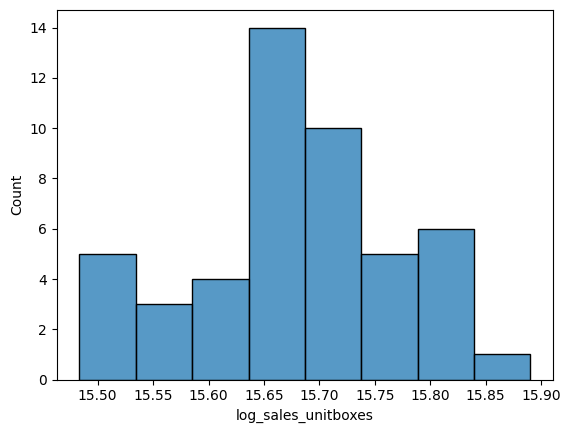

In [61]:
# Opportunity to logarithmically transform sales_unitboxes to diminish outliers
# Calculate log of sales_unitboxes and store it in a new column
df['log_sales_unitboxes'] = np.log(df['sales_unitboxes'])

sns.histplot(df['log_sales_unitboxes'])

#### Max Temperature

<Axes: xlabel='max_temperature', ylabel='sales_unitboxes'>

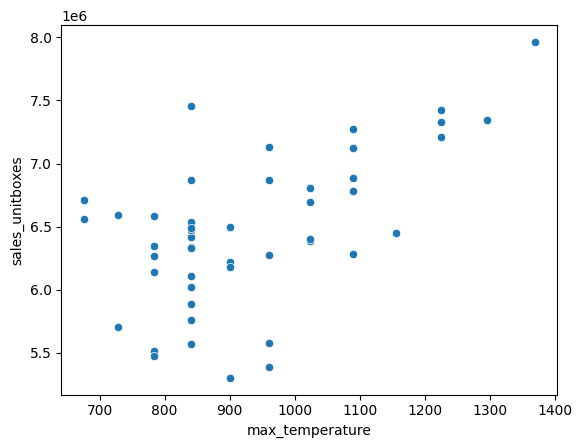

In [62]:
# Opportunity to square max_temperature to see threshold of impact

df['max_temperature_sq'] = df['max_temperature']**2

sns.scatterplot(x = df['max_temperature']**2, y = df['sales_unitboxes'])

#### Holiday Month

In [63]:
# Holiday month as factor to be able to see the effect of each category

df['factor_holiday_month'] = df['holiday_month'].map({0: 'no', 1: 'yes'})
df['factor_holiday_month'] = df['factor_holiday_month'].astype('category')

In [64]:
# See Changes

df.head()

,tperiod,sales_unitboxes,consumer_sentiment,CPI,inflation_rate,unemp_rate,gdp_percapita,itaee,itaee_growth,pop_density,job_density,pop_minwage,exchange_rate,max_temperature,holiday_month,lag_sales_unitboxes,log_lag_sales_unitboxes,log_sales_unitboxes,max_temperature_sq,factor_holiday_month
0,2015-01-01,5516689.143,38.062504,87.110103,-0.09,0.052303,11659.55571,103.765354,0.049717,98.541847,18.260479,9.657861,14.692586,28,0,0.000,15.678678,15.523288,784,no
1,2015-02-01,5387496.113,37.491143,87.275377,0.19,0.053113,11659.55423,103.765354,0.049717,98.541860,18.463294,9.657861,14.921342,31,0,5516689.143,15.523288,15.499591,961,no
2,2015-03-01,5886746.634,38.505219,87.630717,0.41,0.046088,11659.55275,103.765354,0.049717,98.541872,18.641639,9.657861,15.228338,29,0,5387496.113,15.499591,15.588214,841,no
3,2015-04-01,6389182.011,37.842864,87.403840,-0.26,0.051020,11625.74515,107.751835,0.031839,98.828431,18.678763,9.594919,15.226180,32,1,5886746.634,15.588214,15.670117,1024,yes
4,2015-05-01,6448274.629,38.031692,86.967366,-0.50,0.055174,11625.74368,107.751835,0.031839,98.828444,18.675393,9.594919,15.264470,34,0,6389182.011,15.670117,15.679323,1156,no


### *Data Visualization*

#### Histograms

In [65]:
df2 = df.copy() # backup

In [66]:
df2.drop(columns = ['factor_holiday_month'], inplace = True)

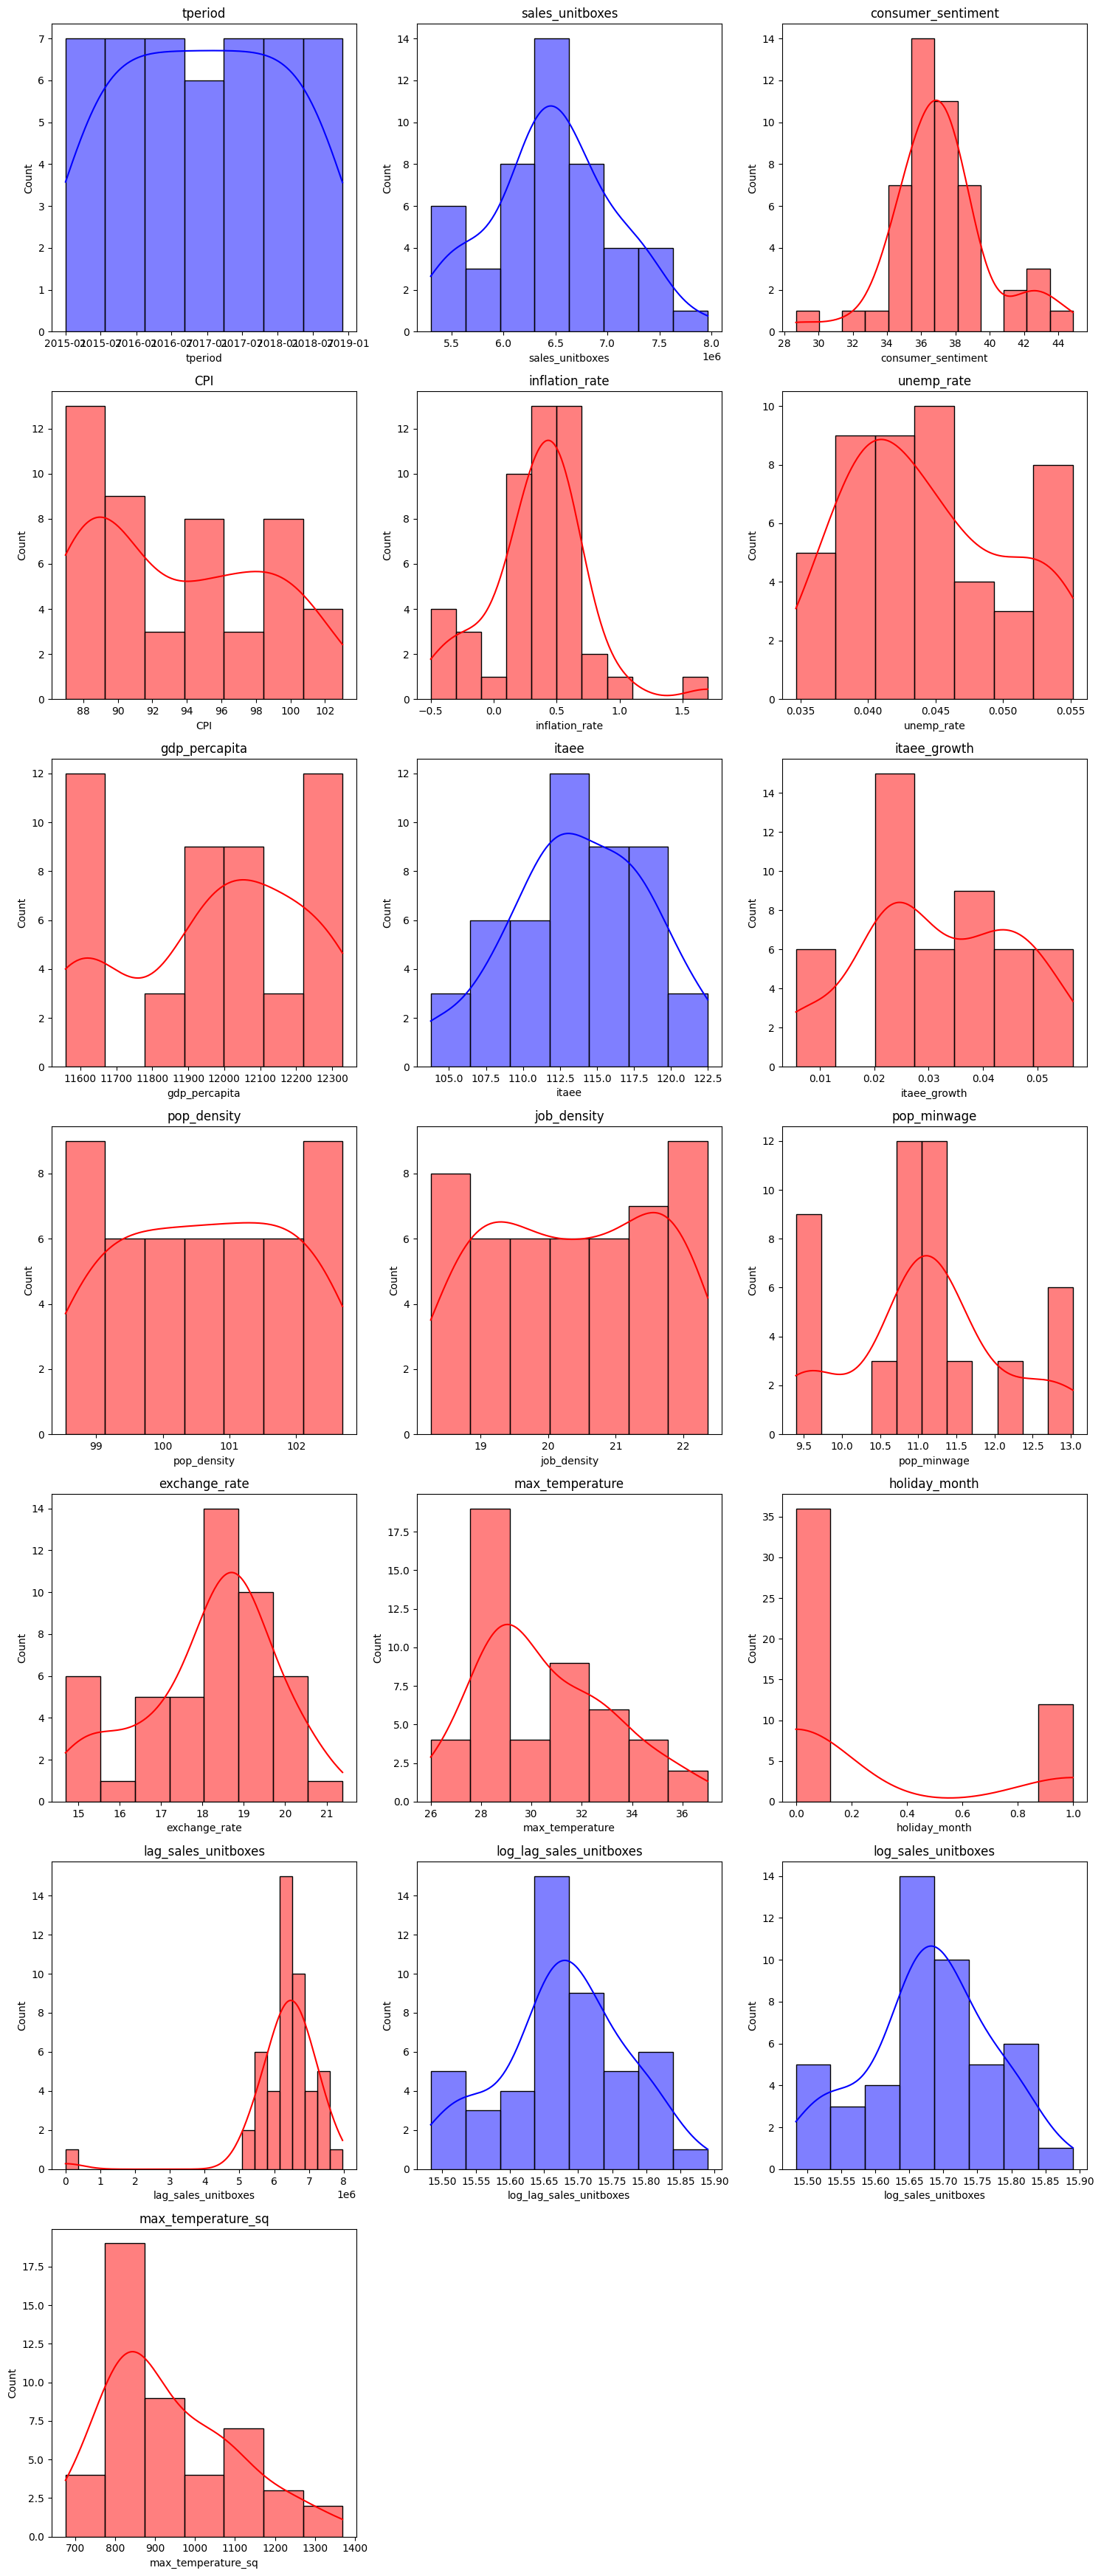

In [67]:
# Distributions of all variables
## Dependent varible is normally distributed
## Opportunity to use natural log transformation on the red varibles (except holiday month)

# Set the number of rows and columns for the grid
num_rows = (len(df.columns) + 2) // 3  # Calculate the number of rows needed
num_cols = 3  # Set the number of columns

# Create the figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Iterate over the columns and create histograms
for i, col in enumerate(df2.columns):
    row = i // num_cols
    col_num = i % num_cols
    ax = axes[row, col_num]

    # Check for normality using Shapiro-Wilk test
    from scipy.stats import shapiro
    _, p_value = shapiro(df[col])
    color = 'red' if p_value < 0.05 else 'blue'  # Set color based on normality

    sns.histplot(df2[col], ax=ax, kde=True, color=color)
    ax.set_title(col)

# Remove any empty subplots
for i in range(len(df2.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### Pair-wised graphs

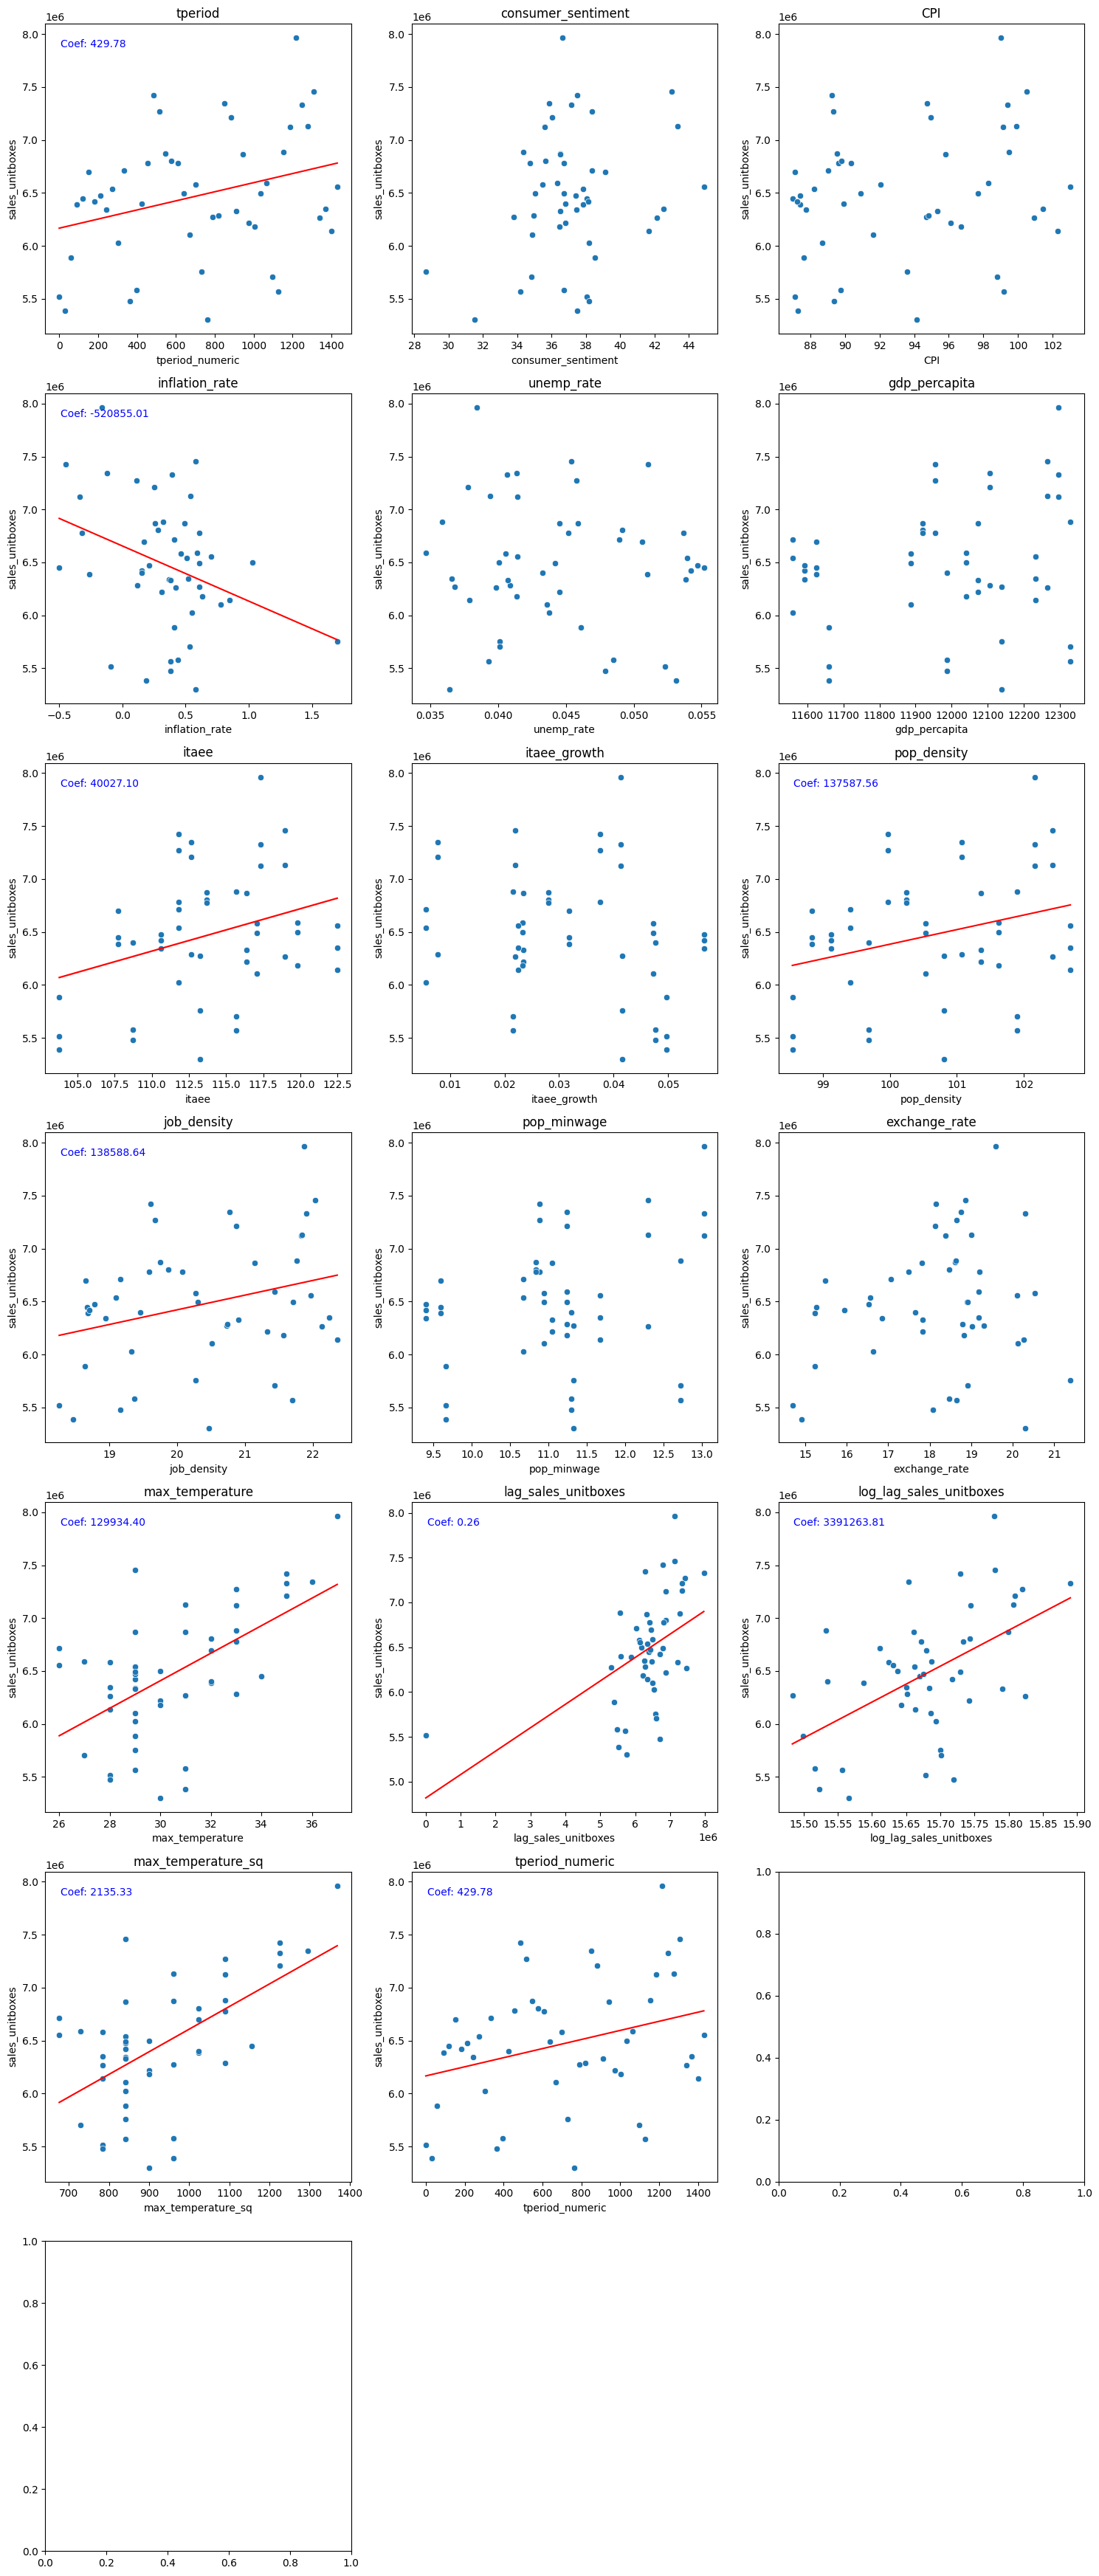

In [113]:
# Scatter Plot with highlighted relevant linear regression coefficients

## Positive Relationships with: tperiod, itaee, pop_density, job_density, max_temperature
## Negative Relationships with: inflation_rate

# Calculate the number of rows and columns for the grid
num_rows = (len(df.columns) - 2) // 3 + 1  # Exclude 'sales_unitboxes' and 'holiday_month'
num_cols = 3

# Create the figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Iterate over the columns (excluding 'sales_unitboxes' and 'holiday_month') and create scatterplots
j = 0 # Initialize a counter for valid columns
for i, col in enumerate(df2.columns):
    if col in ['sales_unitboxes', 'holiday_month', 'factor_holiday_month', 'log_sales_unitboxes']:
        continue

    row = j // num_cols
    col_num = j % num_cols
    ax = axes[row, col_num]

    # Handle date variable
    if df2[col].dtype == 'datetime64[ns]':
        # Convert dates to numerical representation (e.g., days since the first date)
        df2['tperiod_numeric'] = (df2[col] - df2[col].min()).dt.days
        df['tperiod_numeric'] = df2['tperiod_numeric'] # Add the new column to df as well
        X = df2['tperiod_numeric'].values.reshape(-1, 1)
    else:
        X = df2[col].values.reshape(-1, 1)

    y = df['sales_unitboxes'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate p-value for the slope coefficient
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p_value = est2.pvalues[1]

    # Plot the scatterplot with trend line if statistically significant
    sns.scatterplot(x=col if df[col].dtype != 'datetime64[ns]' else 'tperiod_numeric',
                    y='sales_unitboxes', data=df, ax=ax) # Use df here as it now has 'tperiod_numeric'
    if p_value < 0.05:
        sns.lineplot(x=X.flatten(), y=y_pred, color='red', ax=ax)
        # Add regression coefficient to the plot
        coef = model.coef_[0]
        ax.annotate(f'Coef: {coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10, color='blue')

    ax.set_title(col)

    j += 1 # Increment the counter for valid columns

# Remove any empty subplots
for i in range(len(df.columns) - 2, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


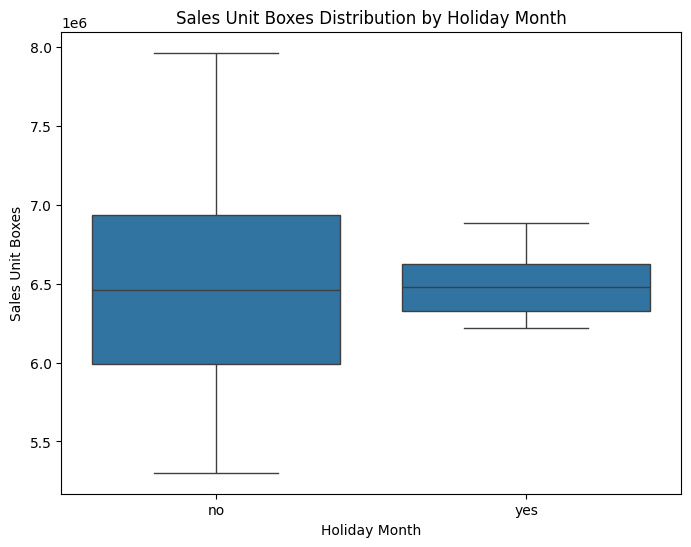

In [69]:
# BOXPLOT
## Greater sales dispersion on no_holiday month.
## Lesser IQR for yes_holiday month.

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='factor_holiday_month', y='sales_unitboxes', data=df)
plt.xlabel('Holiday Month')
plt.ylabel('Sales Unit Boxes')
plt.title('Sales Unit Boxes Distribution by Holiday Month')
plt.show()

#### Correlation Plot

In [72]:
df3 = df.copy() # backup

In [73]:
df3.drop(columns = ['tperiod', 'tperiod_numeric', 'factor_holiday_month', 'log_sales_unitboxes'], inplace = True)

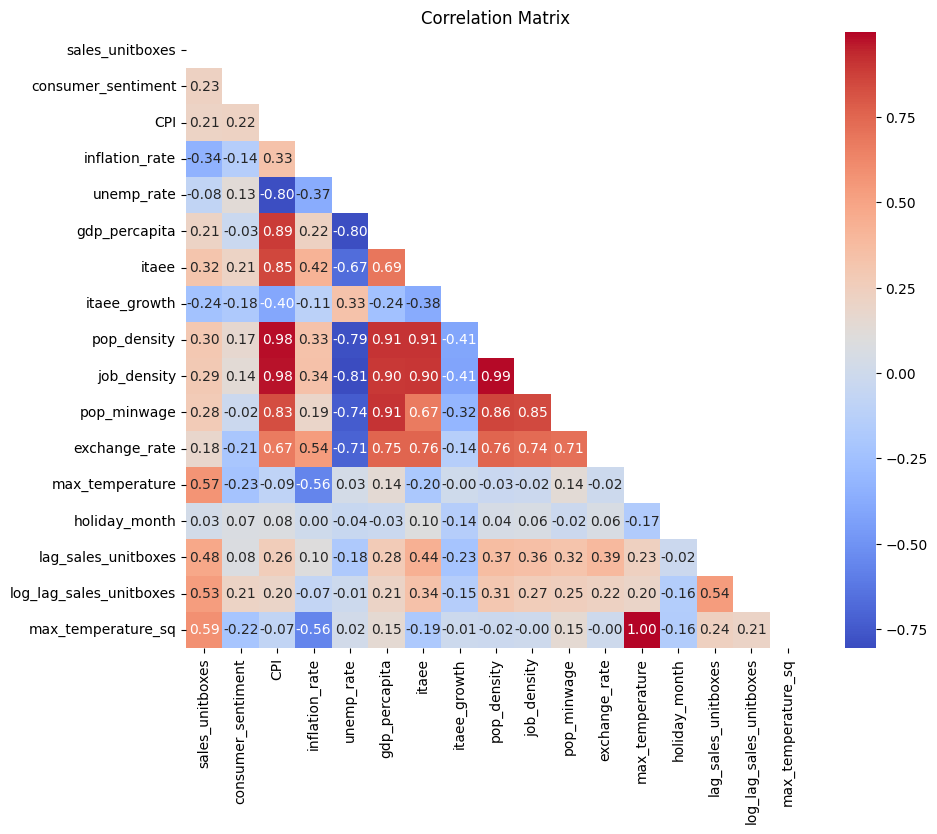

In [74]:
# Correlation Plot
## Most variables are correlated to time
## CPI, Unemployment Rate, GDP per capita, ITAEE, Population Density and Job Density are correlated to each other.
## Sales unit boxes top 3 variables that are correlated are: max_temperature_sqr, lag_sales_unitboxes, and inflation_rate.

# Calculate correlation matrix (excluding 'holiday_month_label')
corr_matrix = df3.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Correlation Matrix')
plt.show()

## **Hypotheses Statements**  

1. Lag is positively relevant for predicting unit box sales.  
H1: β1 > 0

2. Inflation Rate is negatively relevant for predicting unit box sales.  
H1: β2 < 0

3. The monthly maximum temperature is positively relevant for predicting unit box sales.  
H1: β3 > 0

## **Regression Analysis**  

In [75]:
df.head()

,tperiod,sales_unitboxes,consumer_sentiment,CPI,inflation_rate,unemp_rate,gdp_percapita,itaee,itaee_growth,pop_density,...,pop_minwage,exchange_rate,max_temperature,holiday_month,lag_sales_unitboxes,log_lag_sales_unitboxes,log_sales_unitboxes,max_temperature_sq,factor_holiday_month,tperiod_numeric
0,2015-01-01,5516689.143,38.062504,87.110103,-0.09,0.052303,11659.55571,103.765354,0.049717,98.541847,...,9.657861,14.692586,28,0,0.000,15.678678,15.523288,784,no,0
1,2015-02-01,5387496.113,37.491143,87.275377,0.19,0.053113,11659.55423,103.765354,0.049717,98.541860,...,9.657861,14.921342,31,0,5516689.143,15.523288,15.499591,961,no,31
2,2015-03-01,5886746.634,38.505219,87.630717,0.41,0.046088,11659.55275,103.765354,0.049717,98.541872,...,9.657861,15.228338,29,0,5387496.113,15.499591,15.588214,841,no,59
3,2015-04-01,6389182.011,37.842864,87.403840,-0.26,0.051020,11625.74515,107.751835,0.031839,98.828431,...,9.594919,15.226180,32,1,5886746.634,15.588214,15.670117,1024,yes,90
4,2015-05-01,6448274.629,38.031692,86.967366,-0.50,0.055174,11625.74368,107.751835,0.031839,98.828444,...,9.594919,15.264470,34,0,6389182.011,15.670117,15.679323,1156,no,120


### *Base Model*

In [76]:
# Base Regression
model1 = smf.ols(formula= 'sales_unitboxes ~ inflation_rate + exchange_rate + unemp_rate + itaee + consumer_sentiment + pop_density + max_temperature + holiday_month',
                 data = df, missing = 'drop').fit()

# Predictions to calculate residuals
model1_pred = model1.predict(df)

# RMSE
model1_rmse = mean_squared_error(y_true = df['sales_unitboxes'], y_pred = model1_pred, squared = False)
model1_rmse

print(model1.summary())
print(f"RMSE = {model1_rmse}")

                            OLS Regression Results                            
Dep. Variable:        sales_unitboxes   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     9.910
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           2.15e-07
Time:                        21:39:15   Log-Likelihood:                -679.50
No. Observations:                  48   AIC:                             1377.
Df Residuals:                      39   BIC:                             1394.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           6.415e+06   1.16

#### VIF

In [77]:
# There is Multicollinearity present in the base model1

X_VIF = df[['inflation_rate', 'exchange_rate', 'unemp_rate', 'itaee', 'consumer_sentiment', 'pop_density', 'max_temperature', 'holiday_month']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = X_VIF.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(len(X_VIF.columns))]
print(vif_data)

              Feature          VIF
0      inflation_rate     4.996989
1       exchange_rate   622.220048
2          unemp_rate   105.546187
3               itaee  3157.685482
4  consumer_sentiment   287.231506
5         pop_density  3251.085953
6     max_temperature   314.296682
7       holiday_month     1.426465


#### Heteroscedasticity

In [78]:
# Heterocedasticity
# Breusch - Pagan Lagrange Multiplier Test
# if the p-value < 5% then we might have the presence of heterocedascity -- we do not
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(model1.resid,model1.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.794994566570871),
 ('p-value', 0.8751298222395094),
 ('f-value', 0.4185181820618507),
 ('f p-value', 0.9028340881847328)]

#### Normality of Regression Residuals

In [79]:
# Check Normality of Estimated Regression Residuals -- not normally distributed
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(model1.resid)
lzip(name, test)

[('Jarque-Bera', 0.3484140258568524),
 ('Chi^2 two-tail prob.', 0.8401229633408471),
 ('Skew', 0.09360662342614892),
 ('Kurtosis', 2.626960842361761)]

### *Multiple Linear Regression*

In [84]:
# Base Regression
model2 = smf.ols(formula= 'log_sales_unitboxes ~ log_lag_sales_unitboxes + itaee_growth + np.log(inflation_rate + 1)',
                 data = df, missing = 'drop').fit() # All highly correlated with dependent variable w/o multicollinearity

# Predictions to calculate residuals
model2_pred = model2.predict(df)

# RMSE
# Use the new column name 'log_sales_unitboxes' here
model2_rmse = mean_squared_error(y_true = df['log_sales_unitboxes'], y_pred = model2_pred, squared = False)
model2_rmse

print(model2.summary())
print(f"RMSE = {model2_rmse}")

                             OLS Regression Results                            
Dep. Variable:     log_sales_unitboxes   R-squared:                       0.405
Model:                             OLS   Adj. R-squared:                  0.364
Method:                  Least Squares   F-statistic:                     9.967
Date:                 Mon, 26 Aug 2024   Prob (F-statistic):           3.92e-05
Time:                         21:40:31   Log-Likelihood:                 58.819
No. Observations:                   48   AIC:                            -109.6
Df Residuals:                       44   BIC:                            -102.2
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

#### VIF

In [85]:
# There is no multicollinearity present in model2

X_VIF2 = df[['log_lag_sales_unitboxes', 'itaee_growth']].assign(log_inflation_rate = np.log(df['inflation_rate'] + 1))

# VIF dataframe
vif2_data = pd.DataFrame()
vif2_data["Feature"] = X_VIF2.columns

# calculating VIF for each feature
vif2_data["VIF2"] = [variance_inflation_factor(X_VIF2.values, i) for i in range(len(X_VIF2.columns))]
print(vif2_data)

# marginal plot

                   Feature      VIF2
0  log_lag_sales_unitboxes  6.927916
1             itaee_growth  5.881920
2       log_inflation_rate  1.640210


### *Polynomial Regression*

In [98]:
# Polynomial Regression
model3 = smf.ols(formula= 'log_sales_unitboxes ~ lag_sales_unitboxes + itaee_growth + np.log(inflation_rate + 1) + max_temperature_sq + max_temperature' ,
                 data = df, missing = 'drop').fit()

# Predictions to calculate residuals
model3_pred = model3.predict(df)

# RMSE
# Use the new column name 'log_sales_unitboxes' here
model3_rmse = mean_squared_error(y_true = df['log_sales_unitboxes'], y_pred = model3_pred, squared = False)
model3_rmse

print(model3.summary())
print(f"RMSE = {model3_rmse}")

                             OLS Regression Results                            
Dep. Variable:     log_sales_unitboxes   R-squared:                       0.547
Model:                             OLS   Adj. R-squared:                  0.493
Method:                  Least Squares   F-statistic:                     10.14
Date:                 Mon, 26 Aug 2024   Prob (F-statistic):           2.04e-06
Time:                         21:46:20   Log-Likelihood:                 65.373
No. Observations:                   48   AIC:                            -118.7
Df Residuals:                       42   BIC:                            -107.5
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

#### VIF

In [99]:
# There is multicollinearity present in model3 due to the lag

# Use a list to select multiple columns
X_VIF3 = df[['lag_sales_unitboxes', 'itaee_growth', 'max_temperature_sq', 'max_temperature']].assign(log_inflation_rate = np.log(df['inflation_rate'] + 1))

# VIF dataframe
vif3_data = pd.DataFrame()
vif3_data["Feature"] = X_VIF3.columns

# calculating VIF for each feature
vif3_data["VIF3"] = [variance_inflation_factor(X_VIF3.values, i) for i in range(len(X_VIF3.columns))]
print(vif3_data)

               Feature        VIF3
0  lag_sales_unitboxes   41.423077
1         itaee_growth    6.295997
2   max_temperature_sq  243.453426
3      max_temperature  341.003083
4   log_inflation_rate    2.833595


#### Marginal Plot

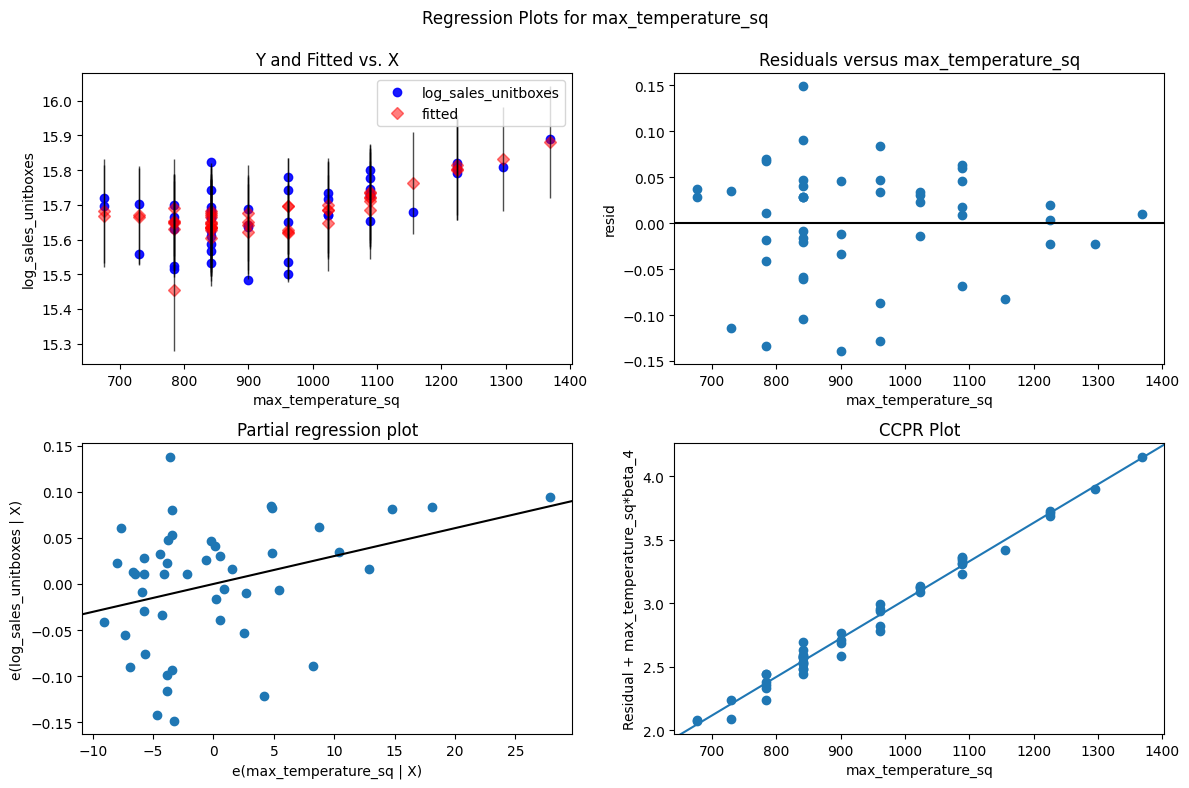

In [103]:
# create residual vs. explanatory variable plot for 'max_temperature_sq'
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model3, 'max_temperature_sq', fig=fig)

### *LASSO*

In [82]:
# Define variables
X = df[['lag_sales_unitboxes',
            'gdp_percapita', 'itaee', 'itaee_growth', 'pop_density',
             'job_density', 'pop_minwage',
             'holiday_month', 'max_temperature_sq', 'max_temperature','log_inflation_rate', 'consumer_sentiment', 'unemp_rate', 'exchange_rate', 'CPI']].assign(
    log_consumer_sentiment = np.log(df['consumer_sentiment'] + 1),
    log_unemployment = np.log(df['unemp_rate'] + 1),
    log_exchange_rate = np.log(df['exchange_rate'] + 1),
    log_CPI = np.log(df['CPI'] + 1)
)

Y = df['log_sales_unitboxes']

In [104]:
# Define variables
X = df[['lag_sales_unitboxes', 'itaee_growth', 'max_temperature_sq', 'max_temperature']].assign(log_inflation_rate = np.log(df['inflation_rate'] + 1))

Y = df['log_sales_unitboxes']

In [105]:
model4 = Lasso(alpha=0.075)
model4.fit(X, Y)
model4_pred = model4.predict(X)

model4_rmse = mean_squared_error(y_true = Y, y_pred = model4_pred, squared = False)

model4_r_sqr = model4.score(X,Y)

print(f"R-squared = {model4_r_sqr}")
print(f"RMSE = {model4_rmse}")

R-squared = 0.45464466234071765
RMSE = 0.0680016716251065


In [106]:
# Coefficients

coeff_model4 = pd.DataFrame(X.columns, columns=['Features'])
coeff_model4['Coefficient Estimate'] = pd.Series(model4.coef_[0])
coeff_model4['Coefficient Estimate'] = coeff_model4['Coefficient Estimate'].fillna(0)
coeff_model4 = coeff_model4.sort_values(by='Coefficient Estimate', ascending=False)

coeff_model4

,Features,Coefficient Estimate
0,lag_sales_unitboxes,3.180031e-08
1,itaee_growth,0.000000e+00
2,max_temperature_sq,0.000000e+00
3,max_temperature,0.000000e+00
4,log_inflation_rate,0.000000e+00


### *RIDGE*

In [107]:
model5 = Ridge(alpha=0.075)
model5.fit(X, Y)
model5_pred = model5.predict(X)

model5_rmse = mean_squared_error(y_true = Y, y_pred = model5_pred, squared = False)

model5_r_sqr = model5.score(X,Y)

print(f"R-squared = {model5_r_sqr}")
print(f"RMSE = {model5_rmse}")

R-squared = 0.5364780509808953
RMSE = 0.06269240876982711


In [108]:
# Coefficients

coeff_model5 = pd.DataFrame(X.columns, columns=['Features'])
coeff_model5['Coefficient Estimate'] = pd.Series(model5.coef_[0])
coeff_model5['Coefficient Estimate'] = coeff_model5['Coefficient Estimate'].fillna(0)
coeff_model5 = coeff_model5.sort_values(by='Coefficient Estimate', ascending=False)
coeff_model5

,Features,Coefficient Estimate
0,lag_sales_unitboxes,3.254543e-08
1,itaee_growth,0.000000e+00
2,max_temperature_sq,0.000000e+00
3,max_temperature,0.000000e+00
4,log_inflation_rate,0.000000e+00


### *Model Selection*

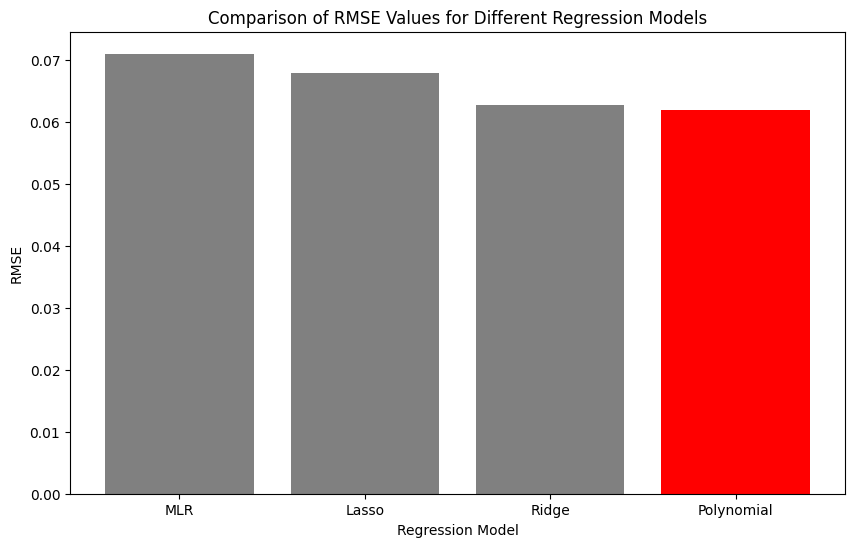

In [111]:
# Define models and their RMSE
models = ['MLR', 'Polynomial', 'Lasso', 'Ridge']
rmse_values = [model2_rmse, model3_rmse, model4_rmse, model5_rmse]

# Combine models and RMSE values into a list of tuples and sort by RMSE in descending order
sorted_models_rmse = sorted(zip(models, rmse_values), key=lambda x: x[1], reverse=True)
sorted_models, sorted_rmse_values = zip(*sorted_models_rmse)

plt.figure(figsize=(10, 6))
plt.bar(sorted_models, sorted_rmse_values, color=['gray', 'gray', 'gray', 'red'])

plt.xlabel('Regression Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Values for Different Regression Models')

plt.show()

The best model is the **Polynomial** and it explains a moderate portion of the variance in log_sales_unitboxes. Significant predictors include lag_sales_unitboxes, max_temperature_sq, and max_temperature, while itaee_growth and np.log(inflation_rate + 1) are not significant.

## **Conclusions**

1. **There is a positive relationship between lagged sales and current sales**. The main explanatory variable is lag_sales_unitboxes, given its coefficient of 3.082e-08. If lag_sales_unitboxes increases by 1 unit, the sales_unitboxes are expected to increase by approximately 3.082e-06%. This supports the alternate hypothesis.

2. **Max temperature has an overall positive impact on sales_unitboxes**. The variable max_temperature_sq has a coefficient of (0.0030) (p-value = 0.024), and max_temperature has a coefficient of (-0.1748) (p-value = 0.035). Despite the negative coefficient for max_temperature, the positive and significant coefficient for max_temperature_sq suggests a more complex relationship. Specifically, as the max_temperature_sq increases by 1 unit, the sales_unitboxes would increase by about 0.3%. This supports the alternate hypothesis, showing that higher temperatures are associated with increased sales.

3. **Changes in the inflation rate do not have a significant impact on sales_unitboxes**. The variable log(inflation_rate + 1) has a coefficient of (-0.0326), which is not statistically significant (p-value = 0.415). Therefore, the alternate hypothesis is not supported by the model’s results.

5. **The percentage change in ITAEE does not have a significant impact on sales_unitboxes**. The variable itaee_growth has a coefficient of (-0.7569), which is not statistically significant (p-value = 0.289). This is corroborated by the lack of relationship on the pair-wised graph.

4. **There are higher sales over time**. The variable tperiod showcased a positive significant single linear regression coefficient with unit box sales where at each month, sales increase about 480 units.


## **References**

- EMIS. Coca-cola Femsa, S.A.B. DE C.V. Perfil de Compañía - México | Finanzas y ejecutivos clave (2024). Emis.com. https://www.emis.com/php/company-profile/MX/Coca-cola_Femsa_SAB_DE_CV_es_1221631.html  
- FEMSA. Acerca de Nosotros | FEMSA. (2023). https://femsa.gcs-web.com/es/company-profile/about-us/